In [2]:
%load_ext autoreload
%autoreload 2
import os
import sys
import copy
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import abstract_gradient_training as agt
from abstract_gradient_training import AGTConfig
from abstract_gradient_training import model_utils
from abstract_gradient_training import test_metrics
from abstract_gradient_training import privacy_utils

sys.path.append('..')
from models.deepmind import DeepMindSmall 
from datasets import oct_mnist

In [5]:
"""Set up environment, config, load pretrained model and datasets."""

results_dir = ".results/"
seed = 1
notebook_id = f"medmnist_{seed}"
model_path = ".models/medmnist.ckpt"  # pretrained model path
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
torch.manual_seed(seed)

batchsize = 5000
nominal_config = AGTConfig(
    fragsize=2000,
    learning_rate=0.2,
    n_epochs=2,
    forward_bound="interval",
    device="cuda:0",
    backward_bound="interval",
    loss="binary_cross_entropy",
    log_level="WARNING",
    lr_decay=2.0,
    clip_gamma=1.0,
    lr_min=0.001,
    early_stopping=False,
    metadata=f"model={model_path}"
)

# get the "DeepMindSmall" model, pretrained on the MedMNIST dataset (without class 2, Drusen)
model = DeepMindSmall(1, 1)
model.load_state_dict(torch.load(model_path))
model = model.to(nominal_config.device)

# get dataloaders, train dataloader is a mix of drusen and the "healthy" class
dl_train, _ = oct_mnist.get_dataloaders(batchsize, 1000, exclude_classes=[0, 1], balanced=True, shuffle=False)
_, dl_test_drusen = oct_mnist.get_dataloaders(batchsize, 1000, exclude_classes=[0, 1, 3], shuffle=False)
_, dl_test_other = oct_mnist.get_dataloaders(batchsize, 1000, exclude_classes=[2], shuffle=False)
_, dl_test_all = oct_mnist.get_dataloaders(batchsize, 1000, shuffle=False)

conv_layers = model[0:5]
linear_layers = model[5:-1]
conv_transform = model_utils.get_conv_model_transform(conv_layers)
param_l, param_n, param_u = model_utils.get_parameters(linear_layers)

/tmp/ipykernel_3894974/1534021654.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


In [6]:
"""Perform a sweep of runs for various values of k."""

def run_with_config(config):
    """If results for this configuration are already computed, load them from disk. Otherwise, run the certified
    training using AGT, then save and return the results."""
    fname = f"{results_dir}/{notebook_id}_{config.hash()}"
    if os.path.isfile(fname):  # run exists, so return the previous results
        param_l, param_n, param_u = torch.load(fname)
    else:
        # check whether the given config should be either unlearning or privacy training
        assert not (config.k_unlearn and config.k_private)
        torch.manual_seed(seed)
        if config.k_private:
            param_l, param_n, param_u = agt.privacy_certified_training(
                linear_layers, config, dl_train, dl_test_drusen, transform=conv_transform
            )
        else:
            param_l, param_n, param_u = agt.unlearning_certified_training(
                linear_layers, config, dl_train, dl_test_drusen, transform=conv_transform
            )
        torch.save((param_l, param_n, param_u), fname)
    return param_l, param_n, param_u

privacy_results = {}  # the results dictionary will be indexed by results[k_private]
k_private_vals = list(range(0, 51, 1)) + list(range(51, 201, 5))

config = copy.deepcopy(nominal_config)
for k_private in k_private_vals:
    config.k_private = k_private
    privacy_results[k_private] = run_with_config(config)
    print(f"\r{k_private}", end="")

/tmp/ipykernel_3894974/628527955.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  param_l, param_n, param_u = torch.load(fname)


196

In [9]:
"""Compute the local epsilons when adding noise calibrated to the global sensitivity."""

test_point, test_label = next(iter(dl_test_all))
param_n = privacy_results[0][1]
delta = 10**-5
epsilons = 0.5, 1.0, 10.0, 20.0, 40.0
local_eps = {}
private_accs = {}


noise_free_acc = test_metrics.test_accuracy(
    param_n, param_n, param_n, test_point, test_label, transform=conv_transform
)[1]

for epsilon in epsilons:
    local_eps[epsilon] = privacy_utils.compute_local_epsilons(
        test_point, test_label, privacy_results, epsilon, delta, transform=conv_transform
    )

    private_accs[epsilon] = privacy_utils.noisy_test_accuracy(
        param_n,
        test_point,
        test_label,
        transform=conv_transform,
        noise_level=1 / epsilon,
        noise_type="laplace",
    )
    print(
        f"Private: global {epsilon = }, private eps = {local_eps[epsilon].mean():.2f}, acc = {private_accs[epsilon]:.2f}"
    )

print(f"Noise-free: acc = {noise_free_acc}")

Private: global epsilon = 0.5, private eps = 0.31, acc = 0.55
Private: global epsilon = 1.0, private eps = 0.46, acc = 0.66
Private: global epsilon = 10.0, private eps = 1.30, acc = 0.87
Private: global epsilon = 20.0, private eps = 1.62, acc = 0.87
Private: global epsilon = 40.0, private eps = 1.97, acc = 0.87
Noise-free: acc = 0.8740000128746033


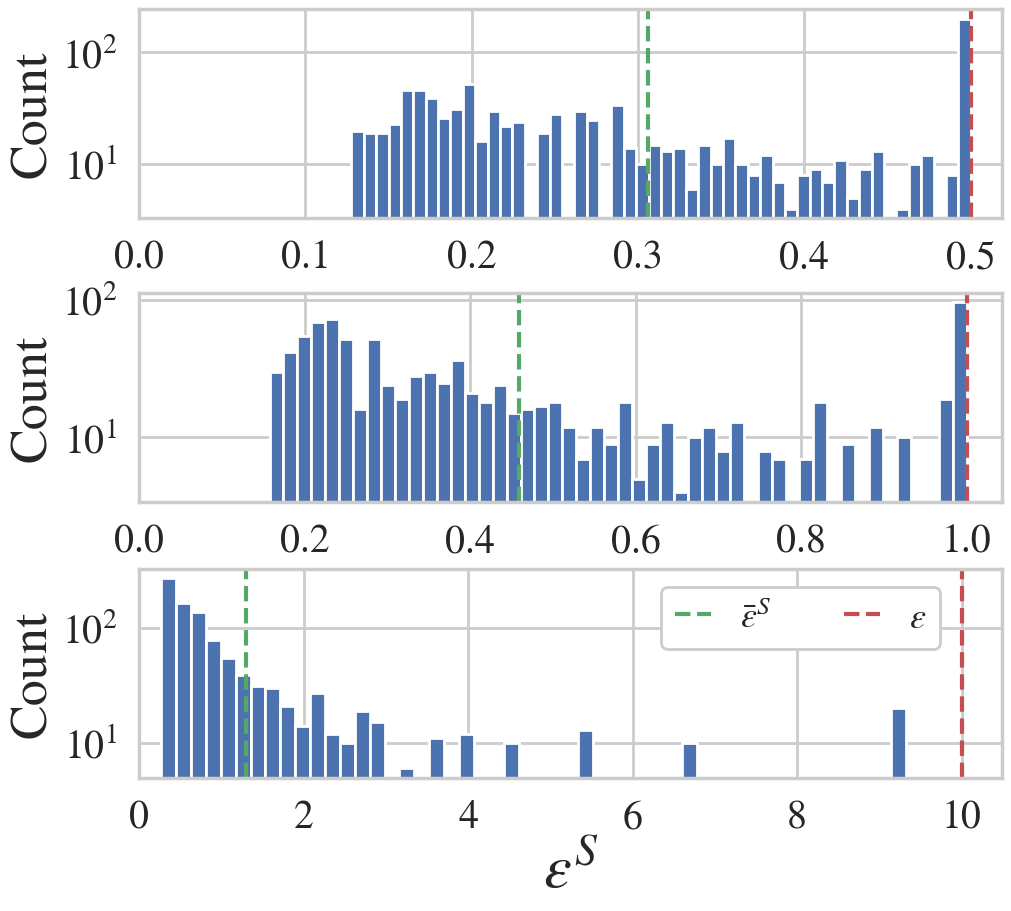

In [10]:
"""Plot the results."""

barcolor = sns.color_palette("deep")[0]
globalcolor = sns.color_palette("deep")[3]
avgcolor = sns.color_palette("deep")[2]

sns.set_theme(context="poster", style="whitegrid", font_scale=1.3)
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"

fig, axs = plt.subplots(3, 1, figsize=(10, 9), layout="constrained", gridspec_kw={"hspace": 0.0, "wspace": 0.0})

for i, epsilon in enumerate(epsilons[:len(axs)]):
    axs[i].set_yscale("log")
    axs[i].hist(local_eps[epsilon].cpu().numpy(), bins=50, color=barcolor, rwidth=1.0)
    axs[i].axvline(local_eps[epsilon].clamp(max=epsilon).cpu().numpy().mean(), color=avgcolor, linestyle="--", label=r"$\bar{\epsilon}^S$")
    axs[i].axvline(epsilon, c=globalcolor, linestyle="--", label="$\epsilon$")
    axs[i].set_ylabel("Count", fontsize="large")
    axs[i].set_xlim(0)

axs[-1].set_xlabel("$\epsilon^S$", fontsize="x-large")
axs[-1].legend(loc="upper right", framealpha=1.0, ncols=2, handlelength=1.0, fontsize="small", bbox_to_anchor=(0.95, 1.0))
plt.savefig(".figures/oct_mnist_local_epsilons.pdf", bbox_inches="tight", dpi=300)